## Overview

We are trying to impement an AI Object Detection System that can
1. Identify multiple food items on a plate under different lighting conditions.
2. Create segmentation masks.
3. Predict the food item and estimate portion size.

## 0. Setting Up Platform

Setting up the platform with updated libraries and device agonistic code.

### Installing necessary Packages

In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+

import torch
from torch import nn
from packaging import version
import torchvision

required_torch = "1.12.0"
required_torchvision = "0.13.0"

if version.parse(torch.__version__) < version.parse(required_torch) or \
   version.parse(torchvision.__version__) < version.parse(required_torchvision):
    print("[INFO] torch/torchvision versions not as required, installing latest versions.")
    # You can change cu121 to cu118 or cpu as needed
    import os
    os.system("pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121")
    # Reload torch and torchvision to reflect new versions
    import importlib
    importlib.reload(torch)
    importlib.reload(torchvision)

print(f"✅ torch version: {torch.__version__}")
print(f"✅ torchvision version: {torchvision.__version__}")

✅ torch version: 2.8.0+cu126
✅ torchvision version: 0.23.0+cu126


And now let's follow best practice and setup device-agnostic code.

> **Note:** If you're using Google Colab, and you don't have a GPU turned on yet, it's now time to turn one on via Runtime -> Change runtime type -> Hardware accelerator -> GPU. **If you do this, your runtime will likely reset and you'll have to run all of the cells above by going Runtime -> Run before.**

If you are running on a CPU-only machine, please use `torch.load()` with `map_location=torch.device('cpu')` to map your storages to the **CPU**.

### Setting up Device

In [ ]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
# Setup Number of CPU Workers
import os
num_workers = os.cpu_count()
print(f"✅ Number of CPU Workers: {num_workers}")

✅ Number of CPU Workers: 2


### Set Seeds

In [ ]:
import random

seeds = 42

torch.manual_seed(seeds)
torch.cuda.manual_seed(seeds)
random.seed(seeds)

print(f"✅ Set seeds {seeds}")

✅ Set seeds 42


## Downloading Data

In [ ]:
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")

#### Download Data

In [ ]:
import requests
import zipfile
from pathlib import Path
from tqdm import tqdm

dataset_path = data_path / "foodSeg103"
zip_path = dataset_path / "foodSeg103.zip"

# If the image folder doesn't exist, download it and prepare it...
if dataset_path.is_dir():
    print(f"{dataset_path} directory exists.")
else:
    print(f"Did not find {dataset_path} directory, creating one...")
    dataset_path.mkdir(parents=True, exist_ok=True)

    # Download Dataset with tqdm progress bar
    url = "https://github.com/Fit-Freak/food-vison/raw/refs/heads/main/data/foodSeg103.zip"
    print("⬇️ Downloading foodSeg103 Dataset ...")
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get("content-length", 0))

    with open(zip_path, "wb") as f, tqdm(
        desc="Downloading",
        total=total_size,
        unit="B",
        unit_scale=True,
        unit_divisor=1024,
        ncols=100
    ) as bar:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
                bar.update(len(chunk))

    # Unzip Dataset
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
      print(f"\n📦 Unzipping {zip_path.name} Dataset...")
      for file in tqdm(zip_ref.namelist(), desc="Extracting", ncols=100):
        zip_ref.extract(file, dataset_path)

    print(f"\n✅ Dataset extracted to {dataset_path}")

Did not find data/foodSeg103 directory, creating one...
⬇️ Downloading foodSeg103 Dataset ...


Downloading: 100%|███████████████████████████████████████████████| 634M/634M [00:10<00:00, 63.4MB/s]



📦 Unzipping foodSeg103.zip Dataset...


Extracting: 100%|███████████████████████████████████████████| 14243/14243 [00:07<00:00, 1914.20it/s]


✅ Dataset extracted to data/foodSeg103


#### WalkThrough Directory

In [ ]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [ ]:
walk_through_dir(dataset_path)

There are 2 directories and 2 images in 'data/foodSeg103'.
There are 2 directories and 0 images in 'data/foodSeg103/train'.
There are 0 directories and 4983 images in 'data/foodSeg103/train/labels'.
There are 0 directories and 4983 images in 'data/foodSeg103/train/images'.
There are 2 directories and 0 images in 'data/foodSeg103/val'.
There are 0 directories and 2135 images in 'data/foodSeg103/val/labels'.
There are 0 directories and 2135 images in 'data/foodSeg103/val/images'.


### Calculate Image Size

In [ ]:
from PIL import Image
import numpy as np
from pathlib import Path
from tqdm import tqdm

image_dirs = [dataset_path / "train/images", dataset_path / "val/images"]

#  --- Collect all image paths ---
image_paths = []
for dir_path in image_dirs:
    image_paths.extend(list(dir_path.glob("*.jpg")))

print(f"📸 Found {len(image_paths)} images in total.")

# --- Compute image sizes ---
widths, heights = [], []

for img_path in tqdm(image_paths, desc="Calculating image sizes"):
    try:
        with Image.open(img_path) as img:
            w, h = img.size
            widths.append(w)
            heights.append(h)
    except Exception as e:
        print(f"⚠️ Error reading {img_path.name}: {e}")

# --- Compute averages ---
avg_width = np.mean(widths)
avg_height = np.mean(heights)

print(f"\n✅ Average Image Size:")
print(f"   Width:  {avg_width:.2f} px")
print(f"   Height: {avg_height:.2f} px")
print(f"   Aspect Ratio (W/H): {avg_width / avg_height:.2f}")


📸 Found 7118 images in total.


Calculating image sizes: 100%|██████████| 7118/7118 [00:00<00:00, 11149.56it/s]


✅ Average Image Size:
   Width:  713.34 px
   Height: 596.71 px
   Aspect Ratio (W/H): 1.20


### Setup Trainning and Validation Paths

In [ ]:
# Setup train and validation paths
train_dir = dataset_path / "train"
train_img_dir = dataset_path / 'train' / 'images'
train_lbl_dir = dataset_path / 'train' / 'labels'
val_dir = dataset_path / "val"
val_img_dir = dataset_path / 'val' / 'images'
val_lbl_dir = dataset_path / 'val' / 'labels'


train_dir, train_img_dir, train_lbl_dir, val_dir, val_img_dir, val_lbl_dir

(PosixPath('data/foodSeg103/train'),
 PosixPath('data/foodSeg103/train/images'),
 PosixPath('data/foodSeg103/train/labels'),
 PosixPath('data/foodSeg103/val'),
 PosixPath('data/foodSeg103/val/images'),
 PosixPath('data/foodSeg103/val/labels'))

### Display a Random Image

In [ ]:
import random

def get_random_image_sample(train_img_dir, val_img_dir, seed=42):
    """
    Pick a random image path from the training or validation image directories.

    Args:
        train_img_dir (Path): Path to the training images directory.
        val_img_dir (Path): Path to the validation images directory.
        seed (int): Random seed for reproducibility.

    Returns:
        tuple[Path, Path | None]: (image_path, corresponding_label_path or None)
    """
    random.seed(seed)
    image_path_list = list(train_img_dir.glob("**/*.jpg")) + list(val_img_dir.glob("**/*.jpg"))

    if not image_path_list:
        raise FileNotFoundError("❌ No images found in the specified directories.")

    # Pick a random image
    random_image_path = random.choice(image_path_list)

    # Build labels path (for segmentation)
    label_path = (
        Path(str(random_image_path).replace("images", "labels"))
        .with_suffix(".png")
    )

    return random_image_path, label_path if label_path.exists() else None

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

def visualize_image_with_mask(img_path, lbl_path=None, alpha=0.5):
    """
    Visualize an image, its mask, and the overlay (combined) image side by side.

    Args:
        img_path (Path): Path to the RGB image file.
        lbl_path (Path, optional): Path to the mask file.
        alpha (float, optional): Transparency level for the mask overlay (0.0–1.0).
    """
    # --- Load the RGB image ---
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # --- Load the mask ---
    mask = None
    if lbl_path and Path(lbl_path).exists():
        mask = np.array(Image.open(lbl_path))

        # Normalize to binary mask if needed
        if mask.max() > 1:
            mask = (mask > 0).astype(np.uint8)

        # Create color mask
        color_mask = np.zeros_like(img)
        color_mask[mask == 1] = [255, 0, 0]  # red

        # Blend the image and mask
        blended = cv2.addWeighted(img, 1 - alpha, color_mask, alpha, 0)
    else:
        blended = img

    # --- Create subplot ---
    plt.figure(figsize=(15, 5))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis("off")

    # Mask
    plt.subplot(1, 3, 2)
    if mask is not None:
        plt.imshow(mask, cmap="gray")
        plt.title("Segmentation Mask")
    else:
        plt.text(0.5, 0.5, "No mask available", ha="center", va="center", fontsize=12)
        plt.title("Segmentation Mask")
    plt.axis("off")

    # Combined overlay
    plt.subplot(1, 3, 3)
    plt.imshow(blended)
    plt.title("Overlay (Image + Mask)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    # --- Metadata ---
    print(f"🖼️ Image Path: {img_path}")
    print(f"🎭 Mask Path: {lbl_path if lbl_path and Path(lbl_path).exists() else 'No mask found'}")
    if mask is not None:
        print(f"✅ Mask Coverage: {mask.sum()} pixels ({mask.mean()*100:.2f}% of image)")

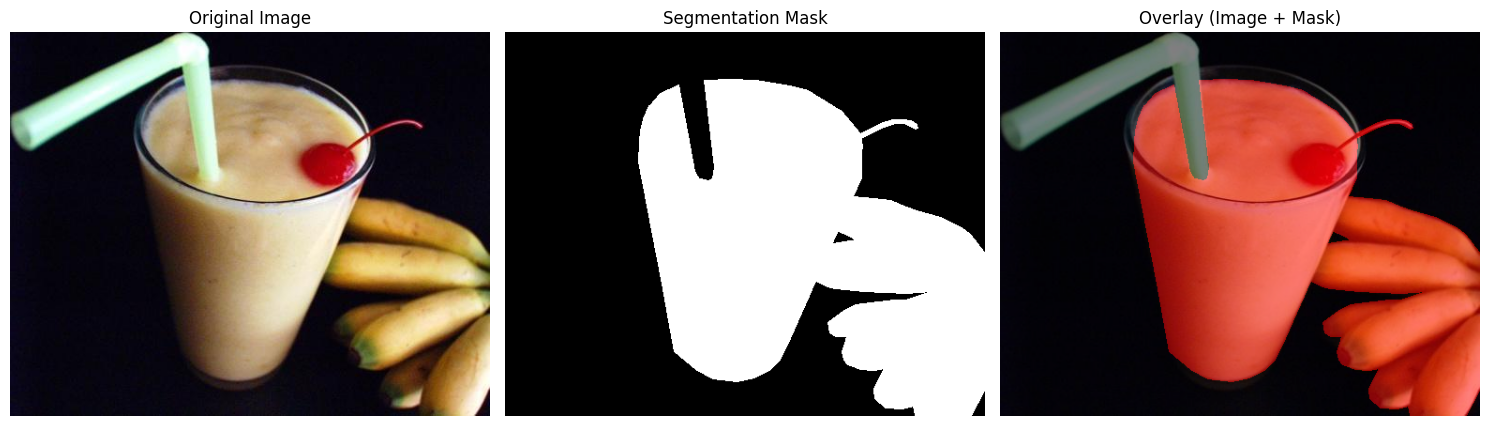

🖼️ Image Path: data/foodSeg103/val/images/392.jpg
🎭 Mask Path: data/foodSeg103/val/labels/392.png
✅ Mask Coverage: 86135 pixels (41.03% of image)


In [ ]:
# Pick a random image
img_path, lbl_path = get_random_image_sample(train_img_dir, val_img_dir, seeds)
# Visualize it
visualize_image_with_mask(img_path, lbl_path)

## Training the Model

### Preparing Data for Training

#### Defining Datasets

In [ ]:
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
import os

class FoodSeg103Dataset(Dataset):
    def __init__(self, img_dir, lbl_dir, transform=None):
        self.img_dir = img_dir
        self.lbl_dir = lbl_dir
        self.transform = transform
        self.images = sorted(os.listdir(img_dir))
        self.labels = sorted(os.listdir(lbl_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        lbl_path = os.path.join(self.lbl_dir, self.labels[idx])
        image = Image.open(img_path).convert("RGB")
        label = Image.open(lbl_path)
        if self.transform:
            image = self.transform(image)
        label = torch.as_tensor(np.array(label), dtype=torch.long)
        return image, label
    
    def __repr__(self):
        # mimic torchvision.datasets.ImageFolder style summary
        transform_str = str(self.transform) if self.transform else "None"
        return (
            f"Dataset FoodSeg103\n"
            f"    Number of datapoints: {len(self)}\n"
            f"    Root location: {self.img_dir}\n"
            f"    StandardTransform\n"
            f"Transform: {transform_str}"
        )


#### Defining Transforms

In [ ]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((512, 512)), # Resize images to 512x512 pixels
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((512, 512)), # Resize images to 512x512 pixels
])

#### Defining DataLoaders

In [ ]:
from torch.utils.data import DataLoader

train_dataset = FoodSeg103Dataset(
    img_dir=train_img_dir,
    lbl_dir=train_lbl_dir,
    transform=train_transform
)

val_dataset = FoodSeg103Dataset(
    img_dir=val_img_dir,
    lbl_dir=val_lbl_dir,
    transform=val_transform
)

#### Display Summary

In [ ]:
print("Train data:")
print(train_dataset)

print("\nTest data:")
print(test_dataset)

### Preparing Model for Inference

#### Loading Pretrained Model

In [ ]:
import torchvision.models.segmentation as seg_models
import torch.nn as nn

NUM_CLASSES = 103  # FoodSeg103 classes

model = seg_models.deeplabv3_resnet101(weights="COCO_WITH_VOC_LABELS_V1")
model.classifier[4] = nn.Conv2d(256, NUM_CLASSES, kernel_size=1)
model.aux_classifier[4] = nn.Conv2d(256, NUM_CLASSES, kernel_size=1)


#### Training Loop

In [ ]:
"""
Training and testing loops for DeepLabv3 (semantic segmentation)
"""
import torch
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

# ---------------------------------------------------------------
# 🔹 Train Step
# ---------------------------------------------------------------
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """
    Performs one training epoch for DeepLabv3.

    Returns:
        (avg_train_loss, pixel_accuracy)
    """
    model.train()
    train_loss, correct_pixels, total_pixels = 0.0, 0, 0

    for X, y in tqdm(dataloader, desc="Training", leave=False):
        X, y = X.to(device), y.to(device)

        # Forward pass → DeepLab outputs dict {"out": logits}
        y_pred = model(X)["out"]

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate pixel accuracy
        preds = torch.argmax(y_pred, dim=1)
        correct_pixels += (preds == y).sum().item()
        total_pixels += torch.numel(y)

    avg_loss = train_loss / len(dataloader)
    pixel_acc = correct_pixels / total_pixels
    return avg_loss, pixel_acc


# ---------------------------------------------------------------
# 🔹 Test Step
# ---------------------------------------------------------------
@torch.inference_mode()
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """
    Evaluates DeepLabv3 model for one epoch.

    Returns:
        (avg_test_loss, pixel_accuracy)
    """
    model.eval()
    test_loss, correct_pixels, total_pixels = 0.0, 0, 0

    for X, y in tqdm(dataloader, desc="Testing", leave=False):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)["out"]
        loss = loss_fn(y_pred, y)
        test_loss += loss.item()

        preds = torch.argmax(y_pred, dim=1)
        correct_pixels += (preds == y).sum().item()
        total_pixels += torch.numel(y)

    avg_loss = test_loss / len(dataloader)
    pixel_acc = correct_pixels / total_pixels
    return avg_loss, pixel_acc


# ---------------------------------------------------------------
# 🔹 Full Training Loop
# ---------------------------------------------------------------
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """
    Trains and validates DeepLabv3 model.
    Tracks pixel accuracy and loss for both sets.
    """
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    model.to(device)

    for epoch in range(epochs):
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)
        test_loss, test_acc = test_step(model, test_dataloader, loss_fn, device)

        print(
            f"Epoch [{epoch+1}/{epochs}] "
            f"| Train Loss: {train_loss:.4f} "
            f"| Train Acc: {train_acc*100:.2f}% "
            f"| Test Loss: {test_loss:.4f} "
            f"| Test Acc: {test_acc*100:.2f}%"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results


In [ ]:
import torch
import torch.nn as nn
import torchvision.models.segmentation as seg_models

# Loss & Optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

# Train for few epochs
results = train(
    model=model,
    train_dataloader=train_loader,
    test_dataloader=test_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=10,
    device=device
)

#### Save Model Checkpoint

In [ ]:
from pathlib import Path

models_path = Path("models/")
models_path.mkdir(parents=True, exist_ok=True)

torch.save(model.state_dict(), models_path / "deeplabv3_foodseg103.pth")